In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [3]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [4]:
!mkdir ../yaml/jan-07-2024
!mkdir ../output/jan-07-2024

In [5]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_number = [10, 20, 50, 100, 150, 200, 500]
ribosome_copy_number = 500
total_trna = 500
ecol_rbs_rate = 10000.0
ribosome_binding_rates = [100.0, 500.0, 1000.0, 1500.0, 10000.0, 15000.0, 100000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.9, 0.1)]
codon_comps_2 = [(0.99, 0.01), (0.9, 0.1), (0.5, 0.5), (0.1, 0.9)]

date = "jan-07-2024"

In [8]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [15]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in transgene_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                    stream.write(cmd)
                    stream.write("\n")

In [6]:
df_master = None

for copy_number in transgene_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in codon_comps_2:
            path = f"../output/{date}/two_codon_multi_transcript_0.9_0.1_{codons[0]}_{codons[1]}_0.9_0.1" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 500, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 500.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)
df_master

,time,species,protein,delta,codon,gfp_rbs,copy_number
9,500.0,ATA_charged,43.000000,-0.666667,1.0,100.0,10
10,500.0,ATA_uncharged,7.000000,0.666667,1.0,100.0,10
11,500.0,GFP,4.666667,0.000000,1.0,100.0,10
12,500.0,TTT_charged,386.666667,-2.666667,1.0,100.0,10
13,500.0,TTT_uncharged,63.333333,2.666667,1.0,100.0,10
...,...,...,...,...,...,...,...
3523,500.0,TTT_uncharged,5.000000,-3.000000,0.1,100000.0,500
3524,500.0,__GFP_rbs,496.333333,11.000000,0.1,100000.0,500
3525,500.0,__cellularProtein_rbs,50.000000,0.000000,0.1,100000.0,500
3526,500.0,free ribosome,0.000000,-0.333333,0.1,100000.0,500


In [19]:
df = df_master[(df_master.copy_number == 50)]
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df.pivot_table(index=['gfp_rbs', 'codon'], columns='species', values='protein')
df

species         ATA_charged  ATA_uncharged           GFP  TTT_charged  \
gfp_rbs  codon                                                          
100.0    0.1      42.666667       7.333333    114.666667   392.000000   
         0.5      41.666667       8.333333    119.333333   385.333333   
         0.9      41.000000       9.000000    110.000000   374.666667   
         1.0      45.000000       5.000000    124.000000   386.666667   
500.0    0.1      39.333333      10.666667    570.000000   379.333333   
         0.5      38.666667      11.333333    589.333333   368.000000   
         0.9      43.333333       6.666667    579.000000   402.666667   
         1.0      46.000000       4.000000    592.666667   399.000000   
1000.0   0.1      34.000000      16.000000   1142.333333   386.666667   
         0.5      41.000000       9.000000   1161.666667   386.666667   
         0.9      41.333333       8.666667   1185.000000   392.000000   
         1.0      42.000000       8.000000   1201.333333   390.666667   
1500.0   0.1      35.666667      14.333333   1676.000000   400.000000   
         0.5      36.333333      13.666667   1724.333333   381.333333   
         0.9      43.333333       6.666667   1785.000000   383.333333   
         1.0      40.333333       9.666667   1794.666667   384.333333   
10000.0  0.1      15.000000      35.000000   5662.333333   421.000000   
         0.5      19.666667      30.333333   8134.000000   369.333333   
         0.9      36.000000      14.000000  10811.000000   340.333333   
         1.0      41.666667       8.333333  11370.666667   327.000000   
15000.0  0.1      16.000000      34.000000   6229.333333   416.666667   
         0.5      20.666667      29.333333   9745.666667   380.000000   
         0.9      38.000000      12.000000  15408.666667   305.000000   
         1.0      42.666667       7.333333  16436.333333   295.333333   
100000.0 0.1       8.000000      42.000000   7192.666667   442.000000   
         0.5       8.000000      42.000000  12812.666667   412.333333   
         0.9      20.666667      29.333333  43801.333333   179.000000   
         1.0      43.333333       6.666667  49903.000000   129.333333   

species         TTT_uncharged  __GFP_rbs  __cellularProtein_rbs  \
gfp_rbs  codon                                                    
100.0    0.1        58.000000  50.000000              49.333333   
         0.5        64.666667  50.000000              48.000000   
         0.9        75.333333  50.000000              49.666667   
         1.0        63.333333  50.000000              49.333333   
500.0    0.1        70.666667  50.000000              48.666667   
         0.5        82.000000  50.000000              50.000000   
         0.9        47.333333  50.000000              48.333333   
         1.0        51.000000  50.000000              48.000000   
1000.0   0.1        63.333333  49.666667              50.000000   
         0.5        63.333333  50.000000              48.000000   
         0.9        58.000000  50.000000              49.666667   
         1.0        59.333333  50.000000              49.000000   
1500.0   0.1        50.000000  49.666667              49.000000   
         0.5        68.666667  50.000000              49.333333   
         0.9        66.666667  50.000000              48.000000   
         1.0        65.666667  50.000000              49.000000   
10000.0  0.1        29.000000  45.666667              49.333333   
         0.5        80.666667  48.333333              48.000000   
         0.9       109.666667  49.666667              48.000000   
         1.0       123.000000  48.666667              48.666667   
15000.0  0.1        33.333333  45.000000              48.666667   
         0.5        70.000000  47.333333              47.666667   
         0.9       145.000000  48.000000              48.000000   
         1.0       154.666667  49.000000              49.000000   
100000.0 0.1         8.000000  39.333333              50.000000   


In [38]:
rcParams['figure.figsize'] = [7, 4]

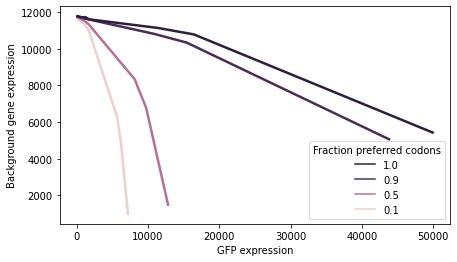

In [39]:
sns.lineplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", linewidth=2.5)
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower right")

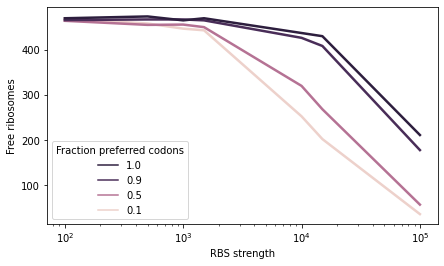

In [54]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "free ribosome", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Free ribosomes")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

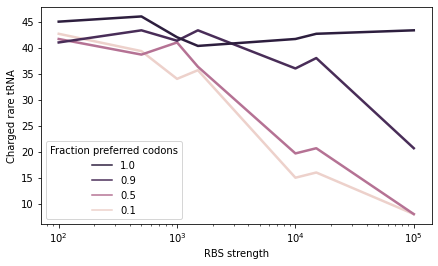

In [51]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "ATA_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Charged rare tRNA")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])

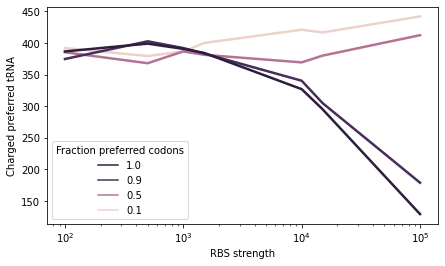

In [52]:
g = sns.lineplot(data=df, x = "gfp_rbs", y = "TTT_charged", hue = "codon", linewidth=2.5)
plt.xscale("log")
plt.xlabel("RBS strength")
plt.ylabel("Charged preferred tRNA")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="Fraction preferred codons", loc="lower left")
#g.set_xticklabels(['0', '0', '2', '4', '6', '8', '10'])